# Strain mapping on polycrystalline sample
This example shows how heterogeneous samples can be segmented automatically and how the segments can be processed independently.

It distinguishes sample regions with different diffraction patterns by clustering frames based on a feature vector that is generated from the presence or absence of specific peaks. These regions are then analyzed separately using the "region of interest" (ROI) feature of LiberTEM. In the end, the regions are merged again for plotting.

Credit goes to Karina Ruzaeva for developing the blobfinder core functionality and introducing the concept of feature vectors and clustering based on them to our work.

Sample data courtesy of Ian MacLaren Ian.MacLaren@glasgow.ac.uk and Shane McCartan s.mccartan.1@research.gla.ac.uk, University of Glasgow

Sample preparation: David Hall and Ilkan Calisir

The dataset is from a solid solution ceramic of bismuth ferrite and barium titanate (ratio: 75%/25%) doped 3% Ti. Chemical segregation of the bismuth ferrite and barium titanate occurs in the formation of the core-shell type structure that you can see in the grain (barium titanate-shell, bismuth ferrite-core). The grain is orientated along the [110] direction as the extra spots that BFO produces at the 1/2 (111) positions are obvious in this orientation. Otherwise the diffraction patterns of BFO and BTO are too similar to distinguish easily.

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
%matplotlib nbagg

In [3]:
import functools

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import hdbscan

In [4]:
import libertem.api as lt
import libertem.udf
import libertem.udf.blobfinder as blb
import libertem.analysis.gridmatching as grm
import libertem.udf.logsum as logsum
import libertem.udf.stddev as stddev
# fullmatch requires hdbscan, which is an optional dependency
import libertem.analysis.fullmatch as fm
import libertem.viz as viz
import libertem.masks as ltmasks

# This is useful for debugging to run everything in
# the same process so that one can use a debugger
#from libertem.executor.inline import InlineJobExecutor

In [5]:
# ctx = lt.Context(executor=InlineJobExecutor())
ctx = lt.Context()

In [6]:
ds = ctx.load(
    'blo',
    path=r'C:\Users\weber\Nextcloud\Projects\Open Pixelated STEM framework\Data\3rd-Party Datasets\Glasgow\10 um 110.blo'
)

In [7]:
(y, x) = ds.shape.nav
(fy, fx) = ds.shape.sig

## Generate the feature vector
We create a standard deviation map to find positions where intensity varies with scan position. The intensity at these positions can serve as a fingerprint for each frame. This allows to drastically reduce the amount of data that is used for clustering.

In [8]:
# Standard deviation map, which highlights pixels that vary across the scan.
# These varying pixels can be used to construct feature vectors.
stddev_result = stddev.run_stddev(ctx, ds)

We choose a fairly large number of peaks (150) since many strong peaks come from the same lattice and are strongly correlated. By increasing the number of peaks we capture weak peaks as well so that they are represented well in the feature vector.

In [9]:
peakfind_params = dict(
    radius=1.5,
    padding=1,
    mask_type='background_subtraction',
    radius_outer=4,
    num_disks=150,
    method='fastcorrelation',
    tolerance=5,
)

r = peakfind_params['radius']

The peaks on the standard deviation map have mostly the same shape as the reflections themselves, that means we can use the peak finder to get their positions.

In [10]:
# Find peaks in the stddev frame
std_found_peaks = blb.get_peaks(parameters=peakfind_params, sum_result=stddev_result['std'])

We visualize the positions on the standard deviation map.

<IPython.core.display.Javascript object>


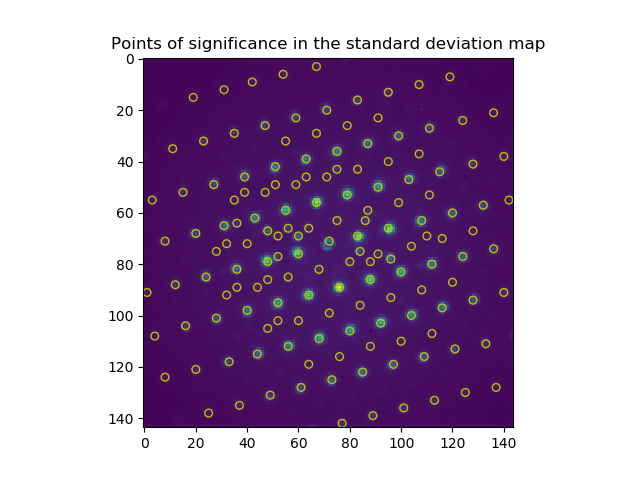

In [11]:
fig, axes = plt.subplots()
axes.imshow(stddev_result['std'])
plt.title("Points of significance in the standard deviation map")

for p in np.flip(std_found_peaks, axis=1):
    axes.add_artist(plt.Circle(p, r, color="y", fill=False))

Now we can use a mask job to generate the feature vector from the data. The `blobfinder` module provides the `feature_vector`method to generate a sparse mask stack that places a matching template on each peak position. Calculating the feature vector is a fast operation thanks to the optimized mask back-end of LiberTEM.

In [12]:
stack = functools.partial(
    blb.feature_vector,
    imageSizeX=fx,
    imageSizeY=fy,
    peaks=std_found_peaks,
    parameters=peakfind_params
)

feature_vec_job = ctx.create_mask_job(
    factories=stack,
    dataset=ds,
    use_sparse=True,
    mask_count=len(std_found_peaks),
    mask_dtype=np.float32
)
feature_vecs = ctx.run(feature_vec_job)

We add x and y coordinate to the vector to include relative position information in the clustering. Spatially distant frames are more likely to belong to separate regions.

In [13]:
yy, xx = np.mgrid[0:y, 0:x]
feature_vecs = np.vstack((feature_vecs, yy.flatten(), xx.flatten()))

Visualization of a few selected feature vector dimensions. The are just virtual darkfield images.

<IPython.core.display.Javascript object>


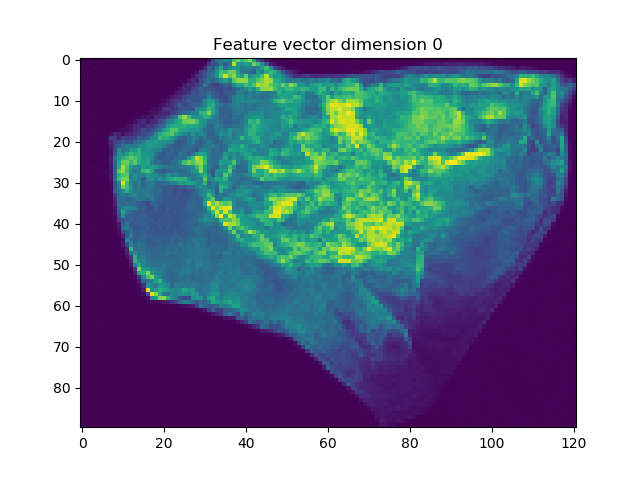

<IPython.core.display.Javascript object>


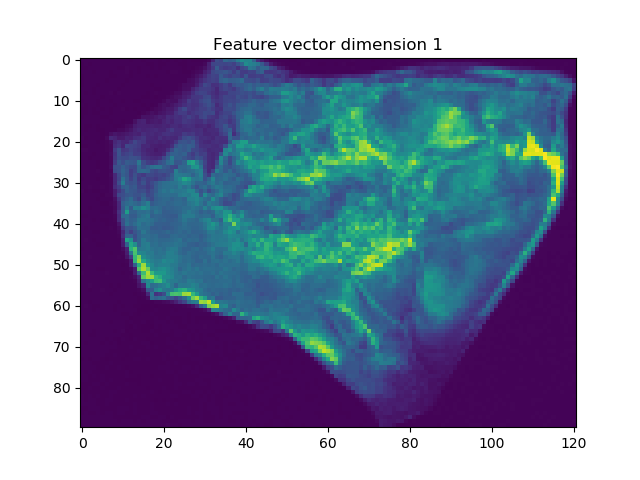

<IPython.core.display.Javascript object>


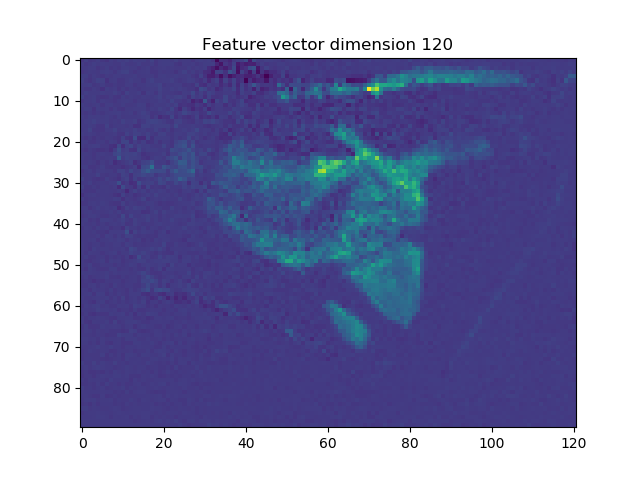

<IPython.core.display.Javascript object>


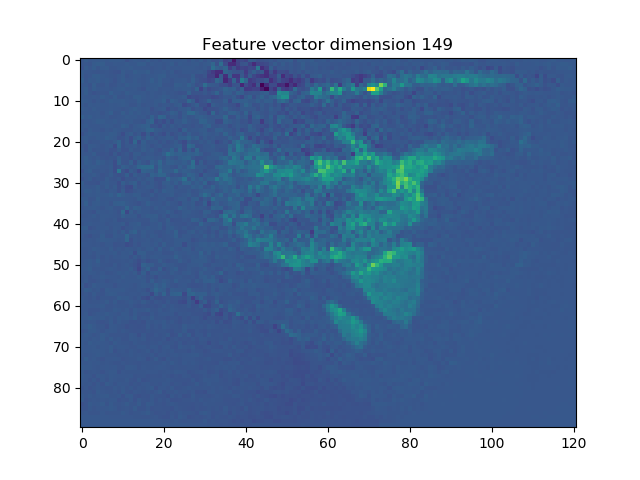

In [14]:
for i in (0, 1, 120, 149):
    fig, axes = plt.subplots()
    axes.imshow(feature_vecs[i, :].reshape((y, x)))
    plt.title("Feature vector dimension %s" % i)

## Clustering
Now we can use the feature vector to cluster the frames in separate categories.

Here we use HDBSCAN, but this might not be optimal in this case. Feedback and ideas are welcome!

The parameter `min_cluster_size` should be reduced to find small precipitates or grains. Here we keep it large since the regions of interest are fairly large.

In [15]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=100,
    min_samples=1,
    allow_single_cluster=True,
    prediction_data=True,
)
clusterer.fit(feature_vecs.T)

HDBSCAN(algorithm='best', allow_single_cluster=True, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=100, min_samples=1, p=None,
    prediction_data=True)

HDBSCAN classifies many points that don't stand out as noise. We use the soft clustering capability to assign the most probable cluster to each frame, even if HDBSCAN doesn't classify it as such. A different clustering algorithm might therefore be more suitable.

In [16]:
softclusters = hdbscan.all_points_membership_vectors(clusterer)

In [17]:
# Try to assign each point to a cluster, even if hdbscan would consider it noise
predom = np.argmax(softclusters, axis=1).reshape((y, x))

<IPython.core.display.Javascript object>


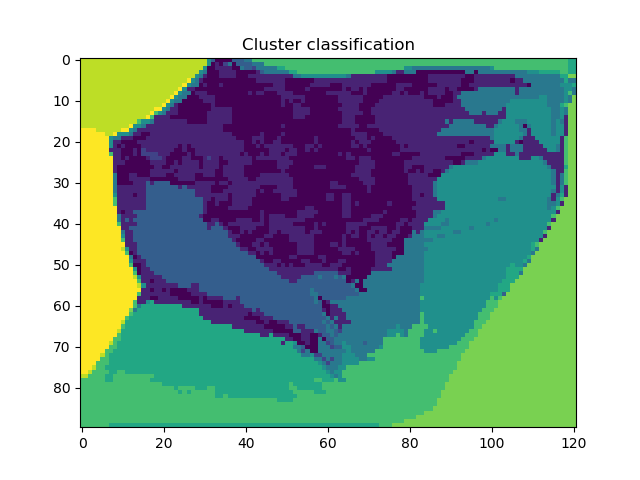

Text(0.5, 1.0, 'Cluster classification')

In [18]:
fig, axes = plt.subplots()
axes.imshow(predom)
plt.title("Cluster classification")

## Process the data individually for each cluster
Now we continue the processing by performing the strain mapping separately for each cluster. LiberTEM UDFs can use a region of interest, which is a boolean array of the same shape as the navigation dimension (scan dimension). It works analogously to fancy indexing for Numpy arrays: `True` values indicate frames that will be processed.

In [19]:
clusters = [dict() for i in range(softclusters.shape[1])]

In [20]:
for i, d in enumerate(clusters):
    d['roi'] = (predom == i).reshape((y, x))
    d['logsum'] = logsum.run_logsum(ctx, dataset=ds, roi=d['roi'])['logsum'].data

We reduce the number of peaks to avoid finding many outliers or weak peaks. The tolerance should be adjusted for each dataset to get a good compromise between finding the "right" peaks and rejecting the "wrong" peaks. This depends on resolution, data quality and magnitude of the strain / deformation.

In [21]:
peakfind_params['num_disks'] = 30
peakfind_params['tolerance'] = 5

for d in clusters:
    d['peaks'] = blb.get_peaks(parameters=peakfind_params, sum_result=d['logsum'])
    d['fullmatch'] = fm.full_match(d['peaks'], parameters=peakfind_params)

We visualize the clusters in the scan dimension and the lattice match on their logsum frame.

<IPython.core.display.Javascript object>


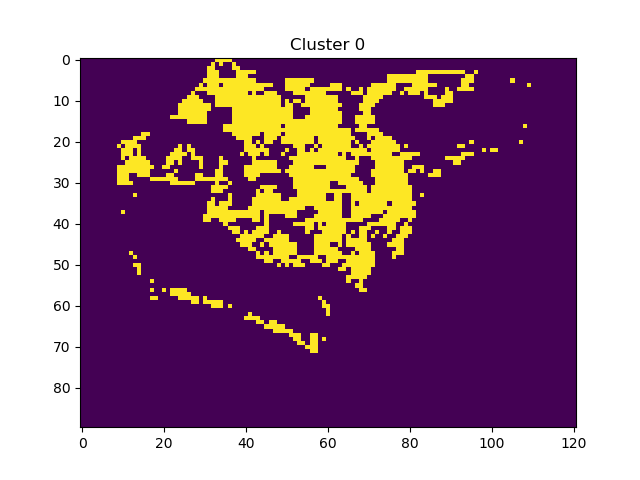

<IPython.core.display.Javascript object>


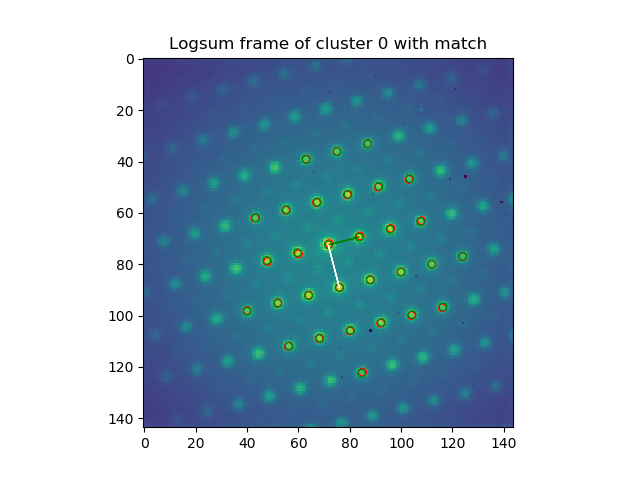

<IPython.core.display.Javascript object>


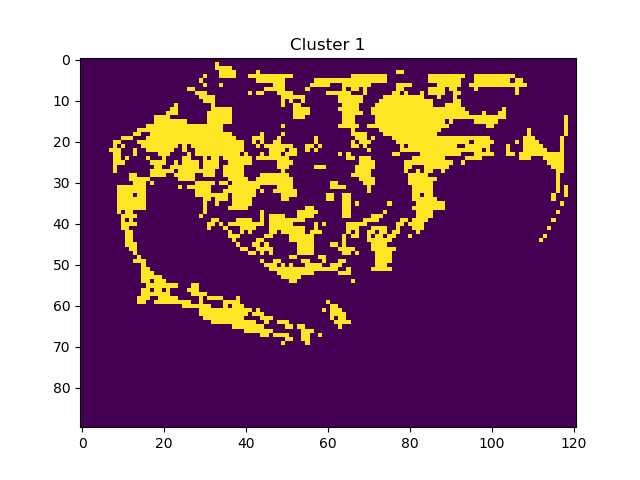

<IPython.core.display.Javascript object>


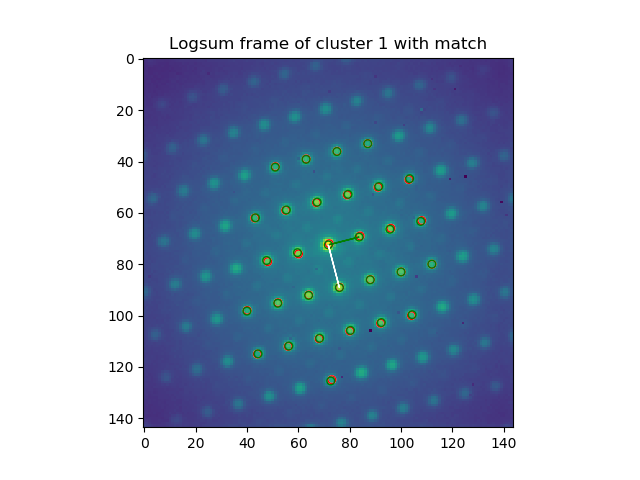

<IPython.core.display.Javascript object>


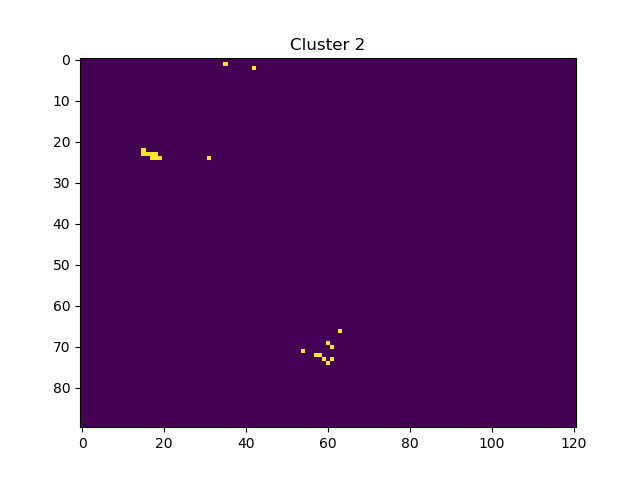

<IPython.core.display.Javascript object>


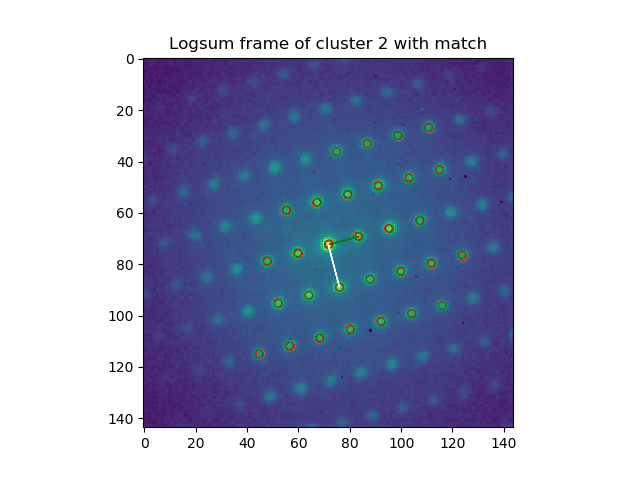

<IPython.core.display.Javascript object>


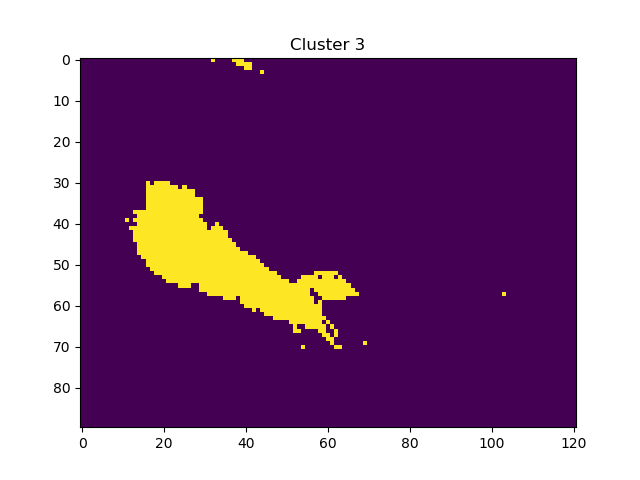

<IPython.core.display.Javascript object>


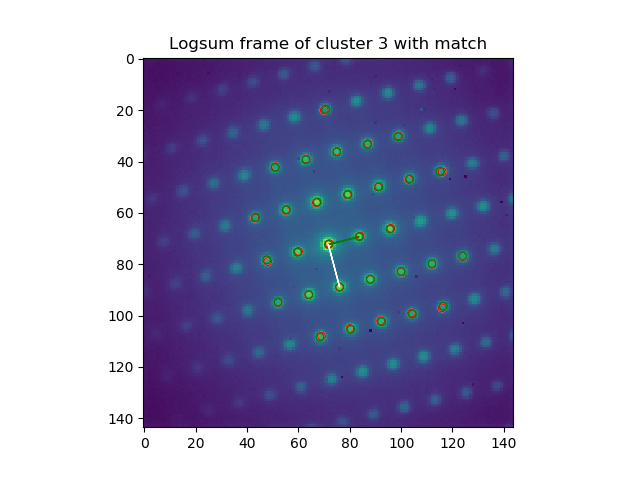

<IPython.core.display.Javascript object>


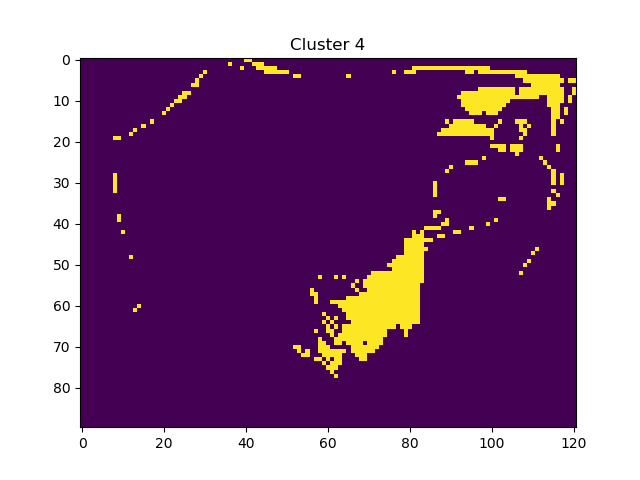

<IPython.core.display.Javascript object>


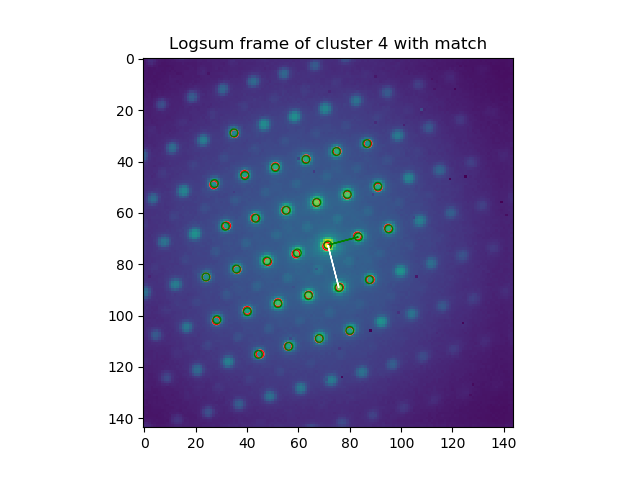

<IPython.core.display.Javascript object>


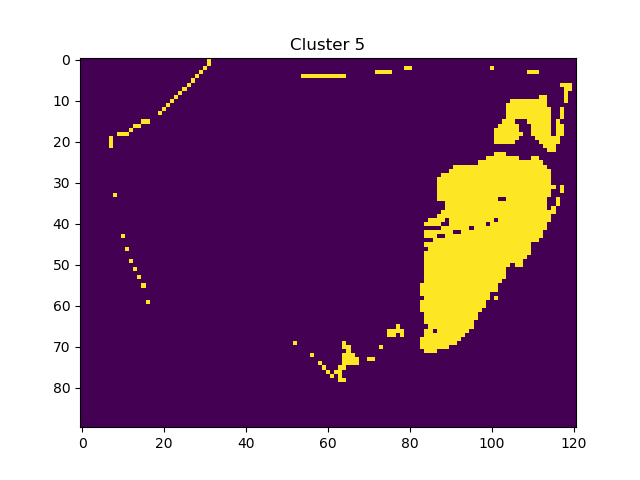

<IPython.core.display.Javascript object>


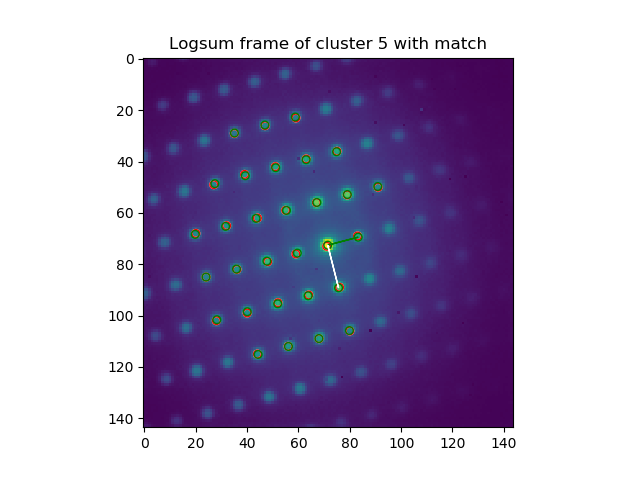

<IPython.core.display.Javascript object>


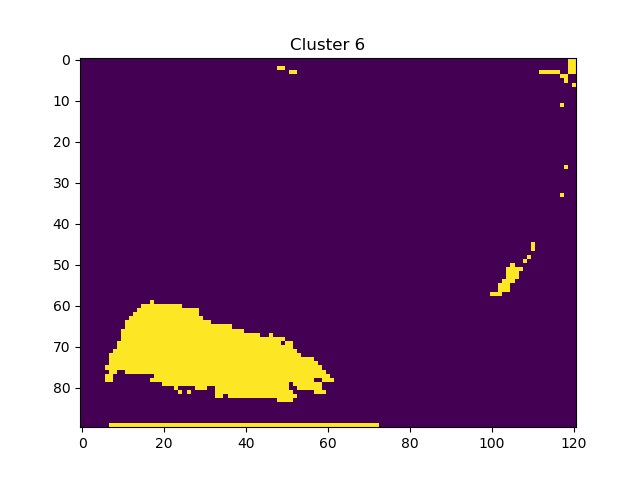

<IPython.core.display.Javascript object>


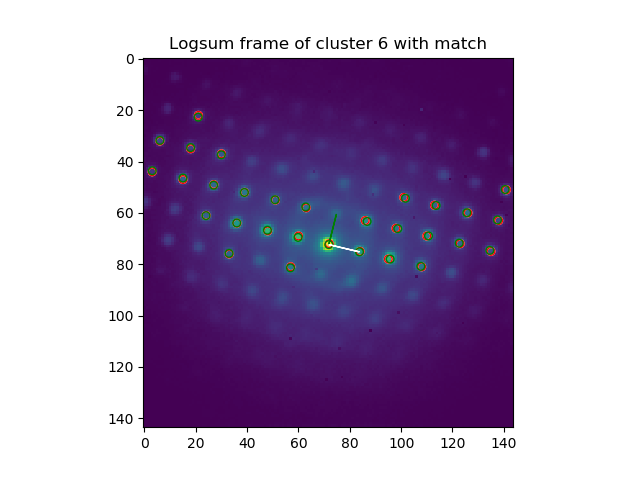

c:\users\weber\appdata\local\conda\conda\envs\libertem\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


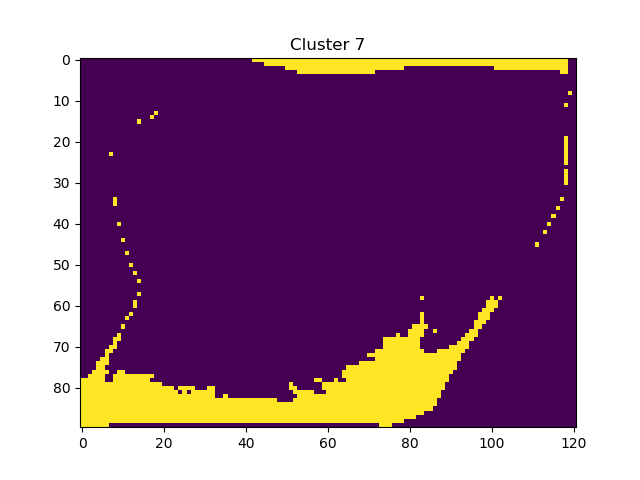

<IPython.core.display.Javascript object>


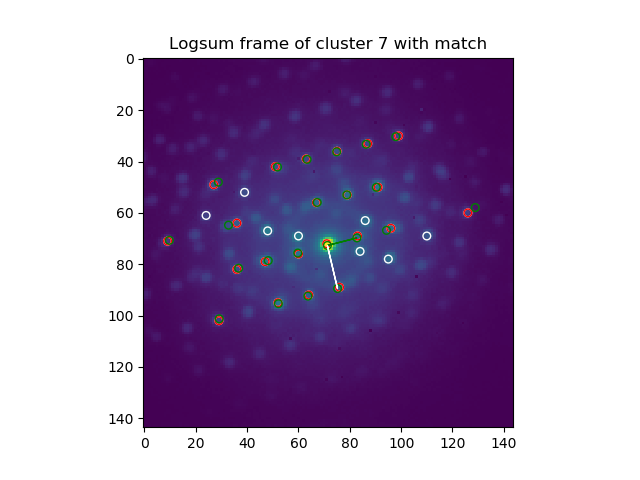

<IPython.core.display.Javascript object>


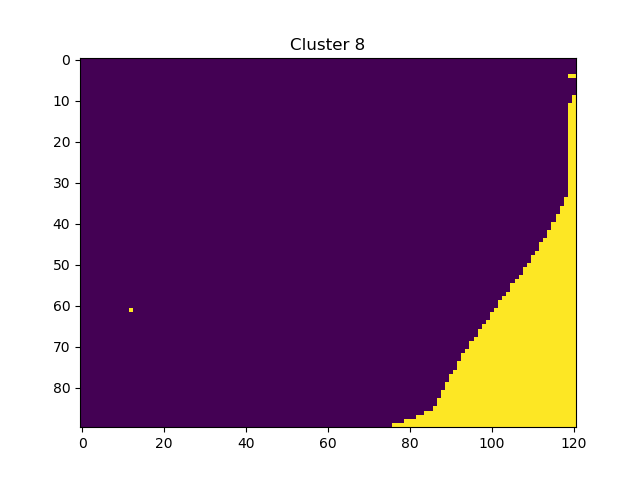

<IPython.core.display.Javascript object>


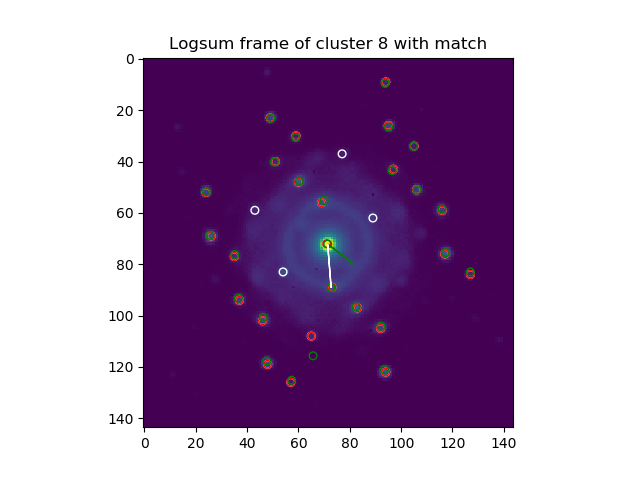

<IPython.core.display.Javascript object>


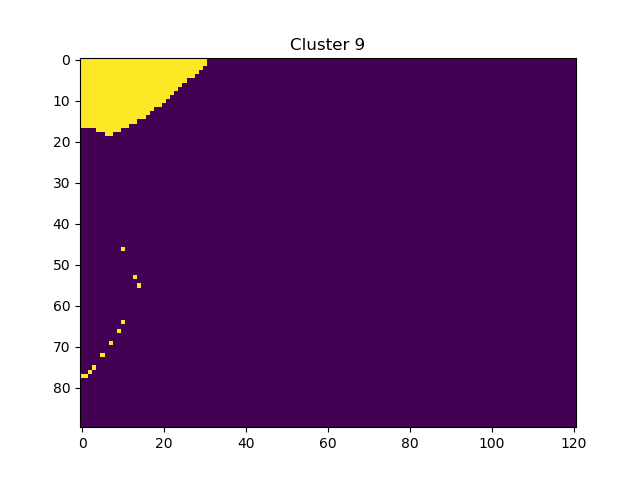

<IPython.core.display.Javascript object>


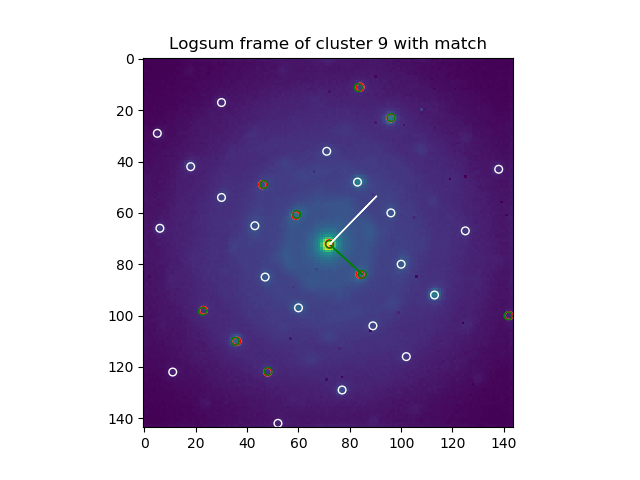

<IPython.core.display.Javascript object>


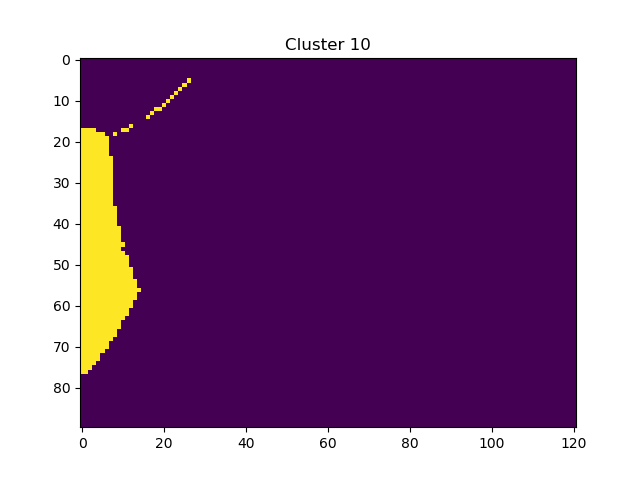

<IPython.core.display.Javascript object>


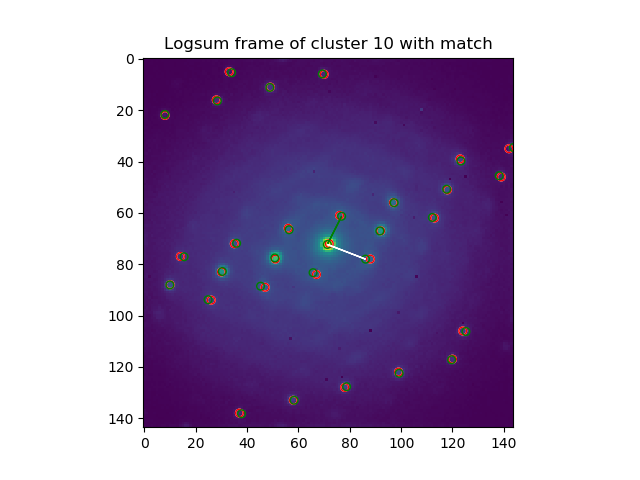

In [22]:
for i, d in enumerate(clusters):
    fig, axes = plt.subplots()
    axes.imshow(d['roi'])
    plt.title("Cluster %s" % i)
    fig, axes = plt.subplots()
    axes.imshow(d['logsum'])
    for p in np.flip(d['peaks'], axis=1):
        axes.add_artist(plt.Circle(p, r, color="w", fill=False))   
    m = d['fullmatch'][0][0]
    
    for p in np.flip(m.refineds, axis=1):
        axes.add_artist(plt.Circle(p, r, color="r", fill=False))
    for p in np.flip(m.calculated_refineds, axis=1):
        axes.add_artist(plt.Circle(p, r, color="g", fill=False))
    plt.arrow(*np.flip(m.zero), *(np.flip(m.a)), color='g')
    plt.arrow(*np.flip(m.zero), *(np.flip(m.b)), color='w')
    plt.title("Logsum frame of cluster %s with match" % i)

### Strain mapping

Now we can calculate a strain map for each cluster

In [23]:
for i, d in enumerate(clusters):
    print("Matching cluster %s of %s" % (i + 1, len(clusters)))
    m = d['fullmatch'][0][0]
    # Refine the lattice parameters for each frame
    (match, indices) = blb.run_refine(
        ctx=ctx,
        dataset=ds,
        zero=m.zero,
        a=m.a,
        b=m.b,
        params=peakfind_params,
        roi=d['roi'],
        indices=np.mgrid[-4:5, -4:5]
    )
    d['match'] = match
    d['indices'] = indices

Matching cluster 1 of 11
Matching cluster 2 of 11
Matching cluster 3 of 11
Matching cluster 4 of 11
Matching cluster 5 of 11
Matching cluster 6 of 11
Matching cluster 7 of 11
Matching cluster 8 of 11
Matching cluster 9 of 11
Matching cluster 10 of 11
Matching cluster 11 of 11


## Assembling the complete result
Fancy indexing allows us to combine the results from all clusters into one.

Note that we use `raw_data` instead of `data` because the latter contains a result for the entire navigation dimension padded with `nan` for results outside the cluster, while the former contains only the frames that are within the ROI.

In [24]:
zeros = np.zeros((y, x, 2), dtype=np.float32)
aas = zeros.copy()
bbs = zeros.copy()
for i, d in enumerate(clusters):
    zeros[d['roi']] = d['match']['zero'].raw_data
    aas[d['roi']] = d['match']['a'].raw_data
    bbs[d['roi']] = d['match']['b'].raw_data

In [25]:
polar_zeros = grm.make_polar(zeros)
polar_aas = grm.make_polar(aas)
polar_bbs = grm.make_polar(bbs)

Here we visualize the fit result for an individual frame. We figure out to which cluster the frame belongs and then use the appropriate data.

<IPython.core.display.Javascript object>


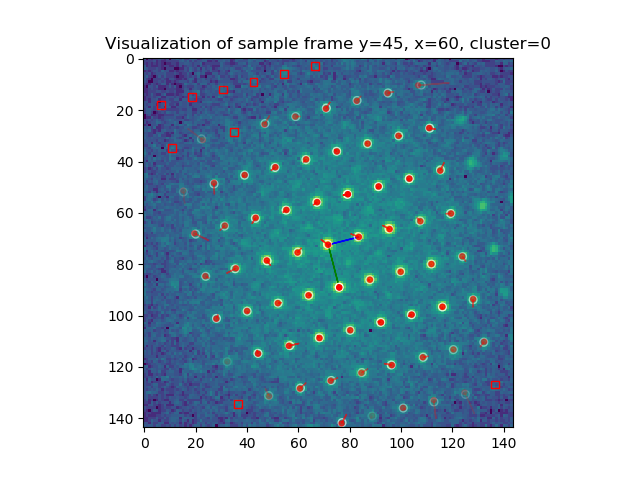

Text(0.5, 1.0, 'Visualization of sample frame y=45, x=60, cluster=0')

In [26]:
fig, axes = plt.subplots()

yy, xx = y // 2, x // 2

cluster = predom[yy, xx]

blb.visualize_frame(
    ctx, ds,
    result=clusters[cluster]['match'],
    indices=clusters[cluster]['indices'],
    r=r,
    y=yy,
    x=xx,
    axes=axes
)

plt.title("Visualization of sample frame y=%s, x=%s, cluster=%s" % (yy, xx, cluster))


## Result visualization
For demonstration, a number of parameters are plotted. Adjusting the plot range reveals details within individual frames. Note how the central grain is largely uniform and smooth despite beging a composite of several clusters. That's because the matching code in `libertem.analysis.fullmatch.full_match` attempts to select grid vectors in a reproducible fashion, i.e. the same grid with different occupancy tends to result in the same grid vectors, as far as that is possible.

Please note that this example did not capture the superlattice in the central grain well. Since the superlattice peaks are weak compared to the main lattice, this would require manual adjustments of the feature vector positions and matching routines. This was omitted because this example is supposed to show the fully automated operation.

<IPython.core.display.Javascript object>


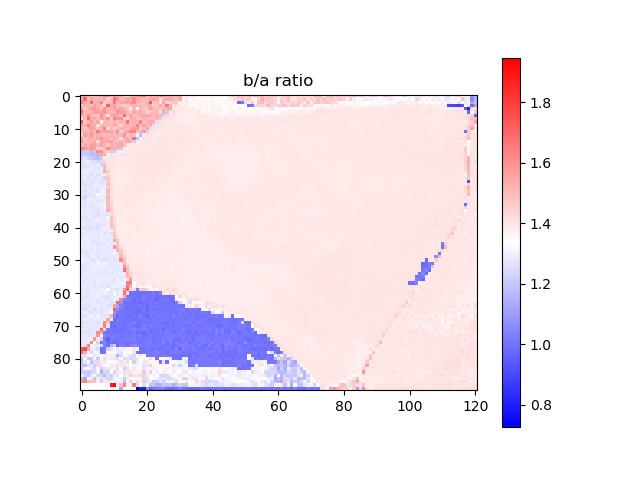

In [27]:
fig, axes = plt.subplots()
# maximum of a/b, b/a to extract "c/a" ratio
plt.imshow(polar_bbs[...,0] / polar_aas[...,0], cmap=cm.bwr)
plt.title("b/a ratio")
plt.colorbar()

<IPython.core.display.Javascript object>


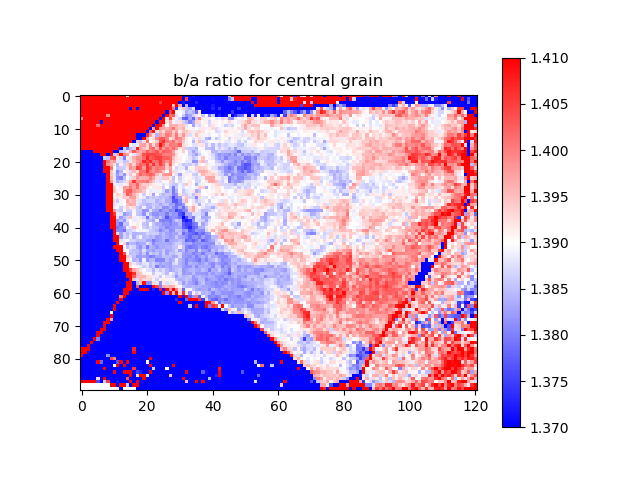

In [28]:
fig, axes = plt.subplots()
# maximum of a/b, b/a to extract "c/a" ratio
plt.imshow(
    polar_bbs[...,0] / polar_aas[...,0],
    cmap=cm.bwr,
    vmin=1.37,
    vmax=1.41,
)
plt.title("b/a ratio for central grain")
plt.colorbar()

<IPython.core.display.Javascript object>


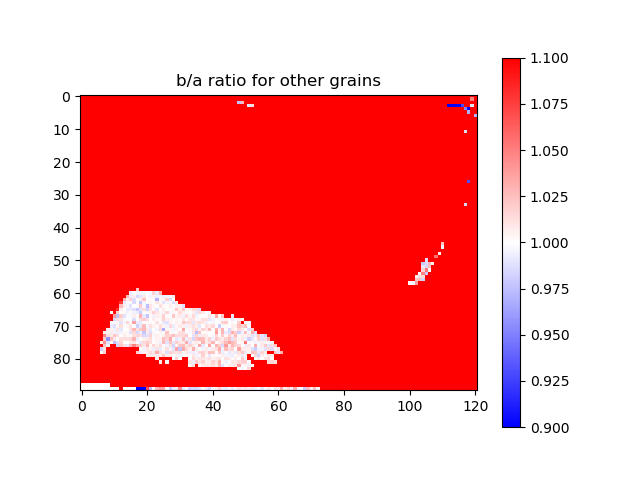

In [29]:
fig, axes = plt.subplots()
# maximum of a/b, b/a to extract "c/a" ratio
plt.imshow(
    polar_bbs[...,0] / polar_aas[...,0],
    cmap=cm.bwr,
    vmin=0.90,
    vmax=1.1,
)
plt.title("b/a ratio for other grains")
plt.colorbar()

<IPython.core.display.Javascript object>


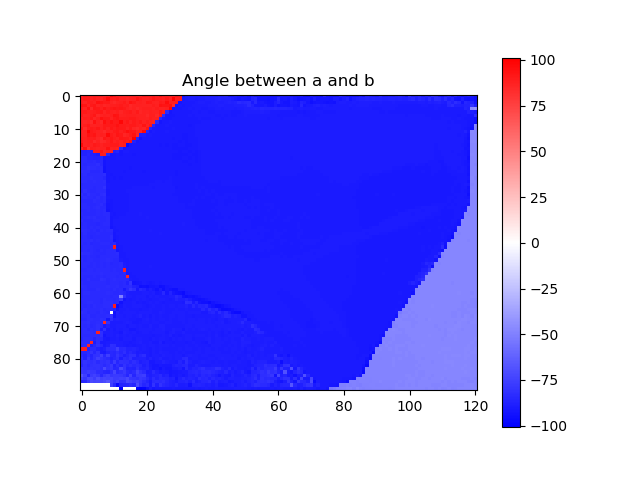

In [30]:
fig, axes = plt.subplots()
# Angle between a and b
plt.imshow((polar_aas[...,1] - polar_bbs[...,1])*180/np.pi, cmap=cm.bwr)
plt.title("Angle between a and b")
plt.colorbar()

<IPython.core.display.Javascript object>


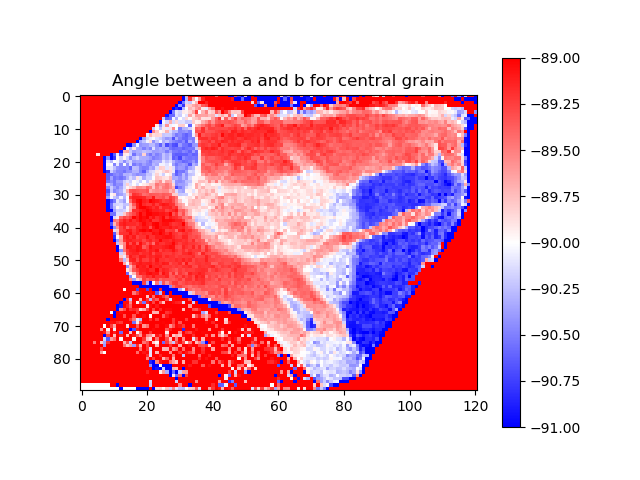

In [31]:
fig, axes = plt.subplots()
# Angle between a and b
plt.imshow((polar_aas[...,1] - polar_bbs[...,1])*180/np.pi, cmap=cm.bwr, vmin=-91, vmax=-89)
plt.title("Angle between a and b for central grain")
plt.colorbar()

<IPython.core.display.Javascript object>


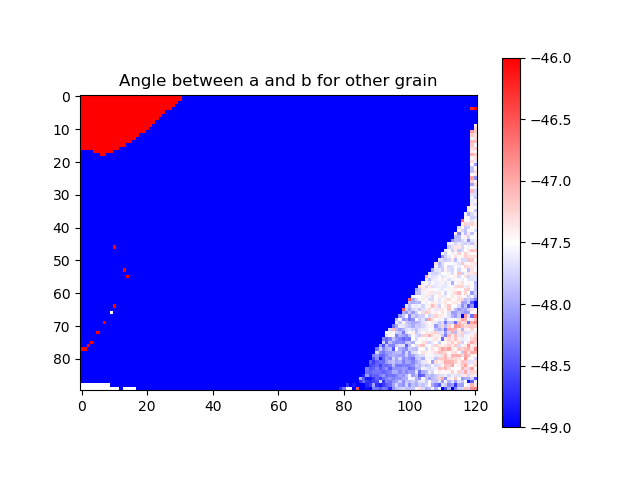

In [32]:
fig, axes = plt.subplots()
# Angle between a and b
plt.imshow((polar_aas[...,1] - polar_bbs[...,1])*180/np.pi, cmap=cm.bwr, vmin=-49, vmax=-46)
plt.title("Angle between a and b for other grain")
plt.colorbar()

<IPython.core.display.Javascript object>


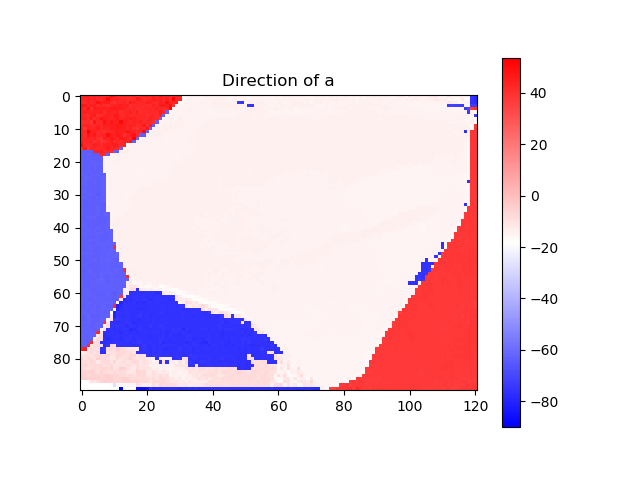

In [33]:
fig, axes = plt.subplots()
# Orientation of "a" vector
plt.imshow(polar_aas[...,1]*180/np.pi, cmap=cm.bwr)
plt.title("Direction of a")
plt.colorbar()

<IPython.core.display.Javascript object>


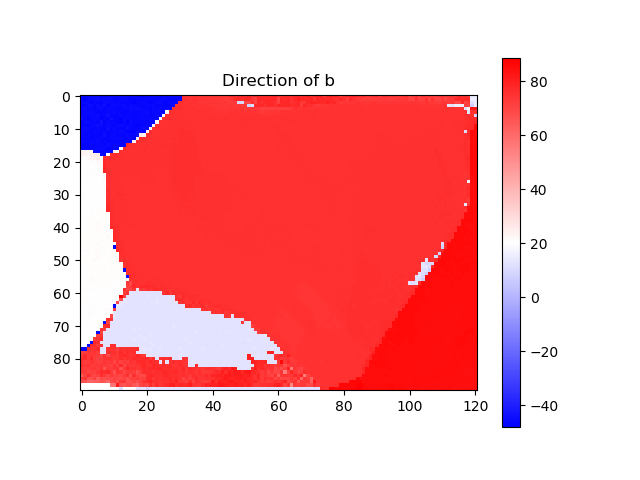

In [34]:
fig, axes = plt.subplots()
plt.imshow(polar_bbs[...,1]*180/np.pi, cmap=cm.bwr)
plt.title("Direction of b")
plt.colorbar()

<IPython.core.display.Javascript object>


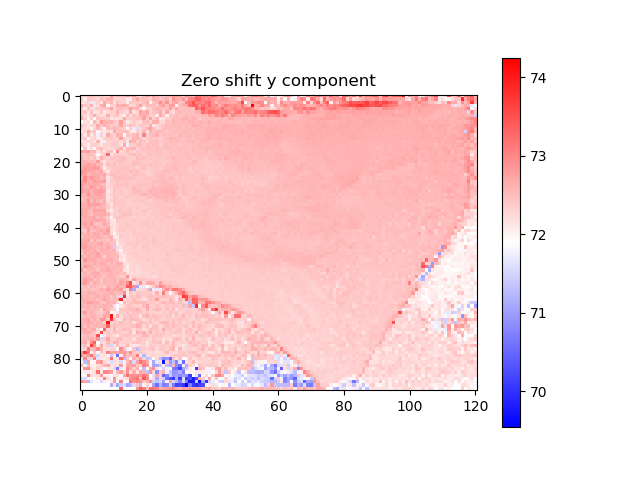

In [35]:
fig, axes = plt.subplots()
# Shift of the y component of the zero point
# Shifts of the zero point might reveal electromagnetic fields under some conditions.
plt.imshow(zeros[...,0], cmap=cm.bwr)
plt.title("Zero shift y component")
plt.colorbar()

<IPython.core.display.Javascript object>


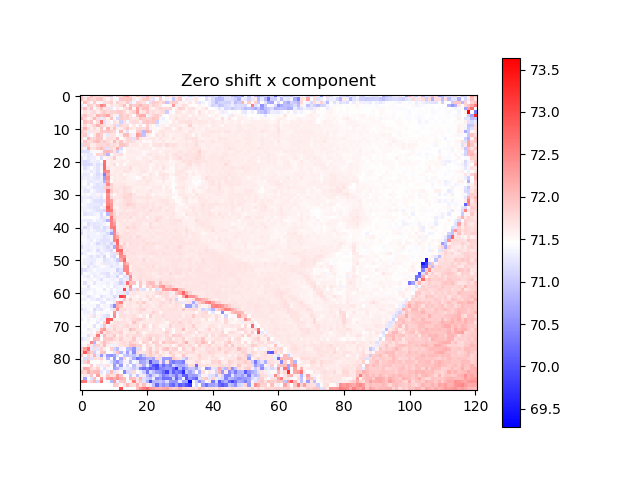

In [36]:
fig, axes = plt.subplots()
# Shift of the x component of the zero point
# Shifts of the zero point might reveal electromagnetic fields under some conditions.
plt.imshow(zeros[...,1], cmap=cm.bwr)
plt.title("Zero shift x component")
plt.colorbar()